# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.285760,False,-0.690434
1,-0.029558,True,5.770692
2,0.288495,False,-0.543351
3,-0.380560,True,2.897410
4,0.403717,False,0.984497
...,...,...,...
995,0.913664,True,7.210884
996,-0.010187,False,0.611818
997,1.154612,True,9.555956
998,0.071398,True,5.216996


<AxesSubplot: xlabel='v0'>

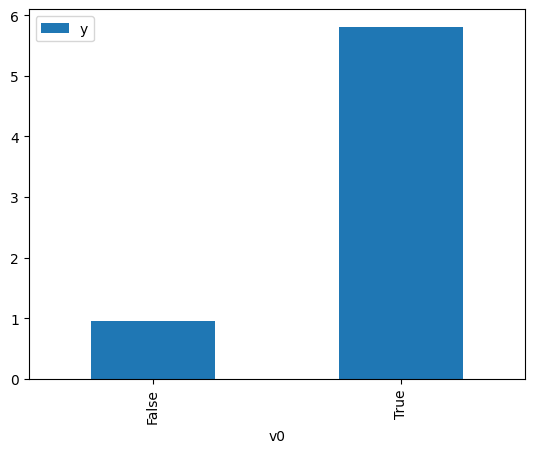

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

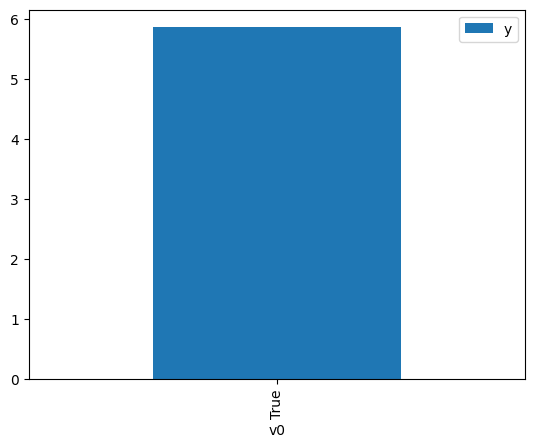

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.084019,False,1.654312,0.500639,1.997447
1,0.462284,False,0.976550,0.470284,2.126376
2,2.191304,False,4.638848,0.337455,2.963354
3,0.231865,False,0.514950,0.488763,2.045982
4,-1.645870,False,-5.343101,0.636102,1.572075
...,...,...,...,...,...
995,-0.517800,False,-0.916400,0.548834,1.822044
996,-0.611545,False,-1.244183,0.556282,1.797648
997,-1.645870,False,-5.343101,0.636102,1.572075
998,1.503125,False,3.016312,0.388530,2.573806


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.518242,True,6.733481,0.534194,1.871980
1,-1.187787,True,1.455641,0.398607,2.508736
2,-0.681865,True,3.378222,0.438147,2.282339
3,0.269556,True,6.487115,0.514263,1.944529
4,0.500095,True,6.270488,0.532742,1.877081
...,...,...,...,...,...
995,-1.046768,True,2.776647,0.409519,2.441888
996,-0.193712,True,2.716079,0.477064,2.096156
997,1.168266,True,7.447160,0.585619,1.707594
998,0.739665,True,7.171595,0.551849,1.812088


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                          1.324e+04
Date:                Sat, 06 May 2023   Prob (F-statistic):                        0.00
Time:                        08:52:13   Log-Likelihood:                         -1418.9
No. Observations:                1000   AIC:                                      2842.
Df Residuals:                     998   BIC:                                      2852.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5545      0.032     79.210      0.000       2.491       2.618
x2             4.9802      0.047    106.680      0.000       4.889       5.072
==============================================================================
Omnibus:                        1.844   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.398   Jarque-Bera (JB):                1.725
Skew:                           0.015   Prob(JB):                        0.422
Kurtosis:                       2.799   Cond. No.                         1.68
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""